### Dropping Cols that only appear once and binning WRBTR by zero and then by quantile

In [52]:
import numpy as np
import pandas as pd
from get_ids import get_ids_of_easy_outliers
#load data
df = pd.read_csv("data/datathon_data.csv")


# Drop BELNR (Account Document Number) since it's just an identifier
ids_to_remove = get_ids_of_easy_outliers(df)
df = df.drop(index = ids_to_remove, columns=['BELNR'])
df=pd.read_csv("C:/Users/Theo/Desktop/Orga/Python/Input/datathon_data.csv")
# Drop BELNR (Account Document Number) since it's just an identifier
df = df.drop(columns=['BELNR'])
categorical_columns = df.select_dtypes(include=['object']).columns

# Loop over categorical columns and drop categories that appear only once
for col in categorical_columns:
    # Get the value counts of each category in the column
    value_counts = df[col].value_counts()
    
    # Find categories that appear only once
    categories_to_drop = value_counts[value_counts == 1].index
    
    # Drop these categories from the column
    df = df[~df[col].isin(categories_to_drop)]
# Identify categorical and numerical columns
target_col= "label"
df['WRBTR_bin'] = pd.cut(df['WRBTR'], bins=[-1, 0, np.inf], labels=['Zero', 'Non-zero'])

# Now apply qcut to the non-zero values
df_non_zero = df[df['WRBTR'] > 0]  # Filter out the zero values
df_non_zero['WRBTR_bin_quantile'] = pd.qcut(df_non_zero['WRBTR'], q=10, labels=False)

# Merge the zero bin back into the DataFrame
df.update(df_non_zero[['WRBTR_bin_quantile']])
df['DMBTR_bin'] = pd.qcut(df['DMBTR'], q=10, labels=False, duplicates='drop')
df.head()


C:\Users\Theo\AppData\Local\Temp\ipykernel_15592\2067224525.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_non_zero['WRBTR_bin_quantile'] = pd.qcut(df_non_zero['WRBTR'], q=10, labels=False)


,WAERS,BUKRS,KTOSL,PRCTR,BSCHL,HKONT,DMBTR,WRBTR,label,WRBTR_bin,DMBTR_bin
0,C3,C31,C9,C92,A3,B1,280979.60,0.00,regular,Zero,3
1,C1,C18,C7,C76,A1,B2,129856.53,243343.00,regular,Non-zero,1
2,C1,C19,C2,C20,A1,B3,957463.97,3183838.41,regular,Non-zero,7
3,C4,C48,C9,C95,A2,B1,2681709.51,28778.00,regular,Non-zero,9
4,C5,C58,C1,C19,A3,B1,910514.49,346.00,regular,Non-zero,7


### Apply SMOTE to get Equal Anom to Regular based on the "hardest 30"

In [50]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
# Drop BELNR (Account Document Number) since it's just an identifier

df = pd.get_dummies(df, columns=['BUKRS', 'WAERS', 'KTOSL', 'PRCTR', 'BSCHL', 'HKONT'], drop_first=True)

# Convert target variable to binary (if it's not already)
df[target_col] = df[target_col].map({'regular': 0, 'anomal': 1})

# drop rare values

# Split your dataset into features and target variable
X = df.drop(columns=['label'])
y = df['label']

# Split data into training and testing sets (you can also split the data first)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to balance the classes in the training data
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Original training set: {X_train.shape}, {y_train.value_counts()}")
print(f"Resampled training set: {X_train_resampled.shape}, {y_train_resampled.value_counts()}")


ValueError: Cannot cast object dtype to float64

### Train Decision tree on SMOTE Dataset and then test on regular

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    106584
           1       0.75      0.75      0.75         4

    accuracy                           1.00    106588
   macro avg       0.87      0.87      0.87    106588
weighted avg       1.00      1.00      1.00    106588


Decision Tree Rules:
|--- BUKRS_C11 <= 0.50
|   |--- PRCTR_C18 <= 0.50
|   |   |--- class: 0
|   |--- PRCTR_C18 >  0.50
|   |   |--- BUKRS_C20 <= 0.50
|   |   |   |--- class: 0
|   |   |--- BUKRS_C20 >  0.50
|   |   |   |--- class: 0
|--- BUKRS_C11 >  0.50
|   |--- WRBTR <= 54423.25
|   |   |--- class: 0
|   |--- WRBTR >  54423.25
|   |   |--- WRBTR <= 54517.63
|   |   |   |--- class: 1
|   |   |--- WRBTR >  54517.63
|   |   |   |--- class: 0



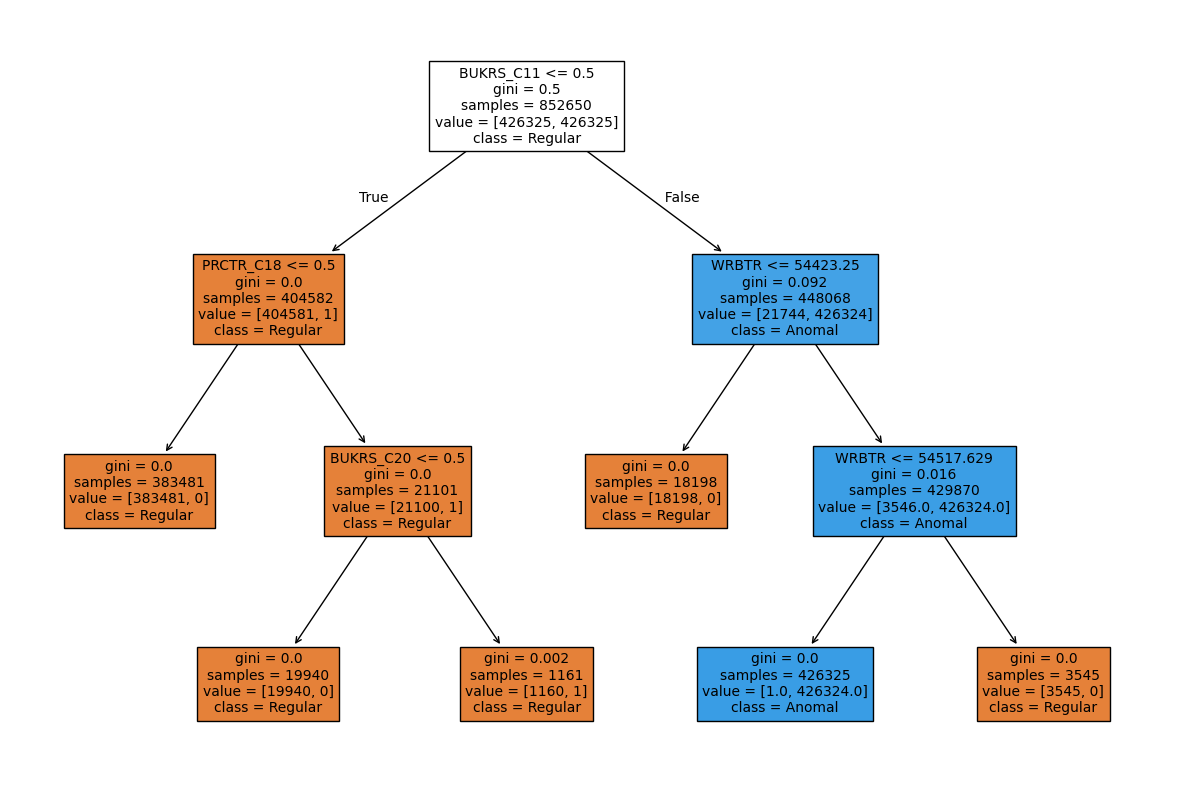

In [40]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree



# Define features and target
X = df.drop(columns=[target_col])  # Features (all columns except target)
y = df[target_col]  # Target variable (0 = regular, 1 = anomal)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to the training data
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Train Decision Tree model on the resampled data
tree_clf = DecisionTreeClassifier(max_depth=3, min_samples_leaf=5, random_state=42)
tree_clf.fit(X_train_resampled, y_train_resampled)

# Evaluate the model
y_pred = tree_clf.predict(X_test)  # Use the original test set (no resampling)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Extract decision rules
print("\nDecision Tree Rules:")
tree_rules = export_text(tree_clf, feature_names=X.columns.tolist())
print(tree_rules)

# Visualize the tree
plt.figure(figsize=(15, 10))
plot_tree(tree_clf, feature_names=X.columns.tolist(), class_names=['Regular', 'Anomal'], filled=True, fontsize=10)
plt.show()


## Random Tessts


In [5]:
print(df.groupby('label')[['DMBTR', 'WRBTR']].describe())


          DMBTR                                                            \
          count          mean           std            min            25%   
label                                                                       
0      532909.0  9.106470e+05  1.879574e+06       2.600000  215905.350000   
1         100.0  6.498506e+07  4.215787e+07  910631.632279  910659.201408   

                                                    WRBTR                \
                50%           75%           max     count          mean   
label                                                                     
0      4.863084e+05  9.749580e+05  9.244552e+07  532909.0  5.444185e+04   
1      9.244551e+07  9.244552e+07  9.244554e+07     100.0  4.172586e+07   

                                                                            \
                std           min          25%           50%           75%   
label                                                                        
0   

In [9]:
df['DMBTR_bin'] = pd.qcut(df['DMBTR'], q=10, labels=False, duplicates='drop')
df['WRBTR_bin'] = pd.qcut(df['WRBTR'], q=10, labels=False, duplicates='drop')


In [37]:
df["WRBTR_bin"].value_counts()

WRBTR_bin
0    319763
4     53294
2     53294
3     53294
1     53294
Name: count, dtype: int64

In [43]:
duplicates = df[df.duplicated(subset='WRBTR')]
print(len(duplicates))
df['WRBTR'].describe()

395434


count    5.329390e+05
mean     5.444185e+04
std      4.399694e+05
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      2.627912e+04
max      5.958504e+07
Name: WRBTR, dtype: float64